# Naive Bayes: Gaussian, Multinomial y Bernulli

## 1. Librerias y configuraciones previas

In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
import math

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split


#Escalar Variables
from sklearn.preprocessing import MinMaxScaler


#Evaluación del modelo
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


#Creación de modelo
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB


# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## 2. Funciones

In [2]:
# Funcion para imprimir la curva ROC

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [3]:
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

## 3. Carga del dataset

In [4]:
#Se crea un dataframe d con los datos obtenidos de archivo de entrada
d = pd.read_csv("./datasets/03_cancer.csv")

In [5]:
## Cargar datos con colab
## =============================================================================

#from google.colab import drive 
#import os

#drive.mount('/gdrive')

In [6]:
#os.chdir("/gdrive/MyDrive/ModelosCuantitativosPython/Notebooks")
#!ls

In [7]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [8]:
#Borrando columnas que no se emplearán

d = d.drop(["id"], axis = 1)
d = d.drop(["Unnamed: 32"], axis = 1)

In [9]:
#Verificación y eliminación de registros duplicados

#Verificación de registros duplicados
d.loc[d.duplicated()]

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst


In [10]:
d['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [11]:
#Reemplazo de valores para la agrupación de categorías

d["diagnosis"].replace("M",0,inplace=True)
d["diagnosis"].replace("B",1,inplace=True)

# Cambiar el tipo de datos de object a float
d['diagnosis'] = d['diagnosis'].astype('int')


## 4. Visualización de datos

### Variables de entrada

In [12]:
#Lista de variables numéricas

numCols=d.select_dtypes(include = ['float64','float64','int32','int64']).columns.tolist()

d[numCols].head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [13]:
#Generación de la matriz de correlación
matrizCorr = d.corr()

In [14]:
#Matriz de correlación ordenada

#Creación de la matriz
df_corr= tidy_corr_matrix(matrizCorr)


#Selección de las variables correlacionadas con el diagnóstico
df_filtrado = df_corr.loc[df_corr['variable_2'] == 'diagnosis']

#Se identifican las 8 correlaciones más fuertes
df_filtrado = df_filtrado[df_filtrado['abs_r']>=0.5][:8] 
df_filtrado

,variable_1,variable_2,r,abs_r
868,concave points_worst,diagnosis,-0.793566,0.793566
713,perimeter_worst,diagnosis,-0.782914,0.782914
248,concave points_mean,diagnosis,-0.776614,0.776614
651,radius_worst,diagnosis,-0.776454,0.776454
93,perimeter_mean,diagnosis,-0.742636,0.742636
744,area_worst,diagnosis,-0.733825,0.733825
31,radius_mean,diagnosis,-0.730029,0.730029
124,area_mean,diagnosis,-0.708984,0.708984


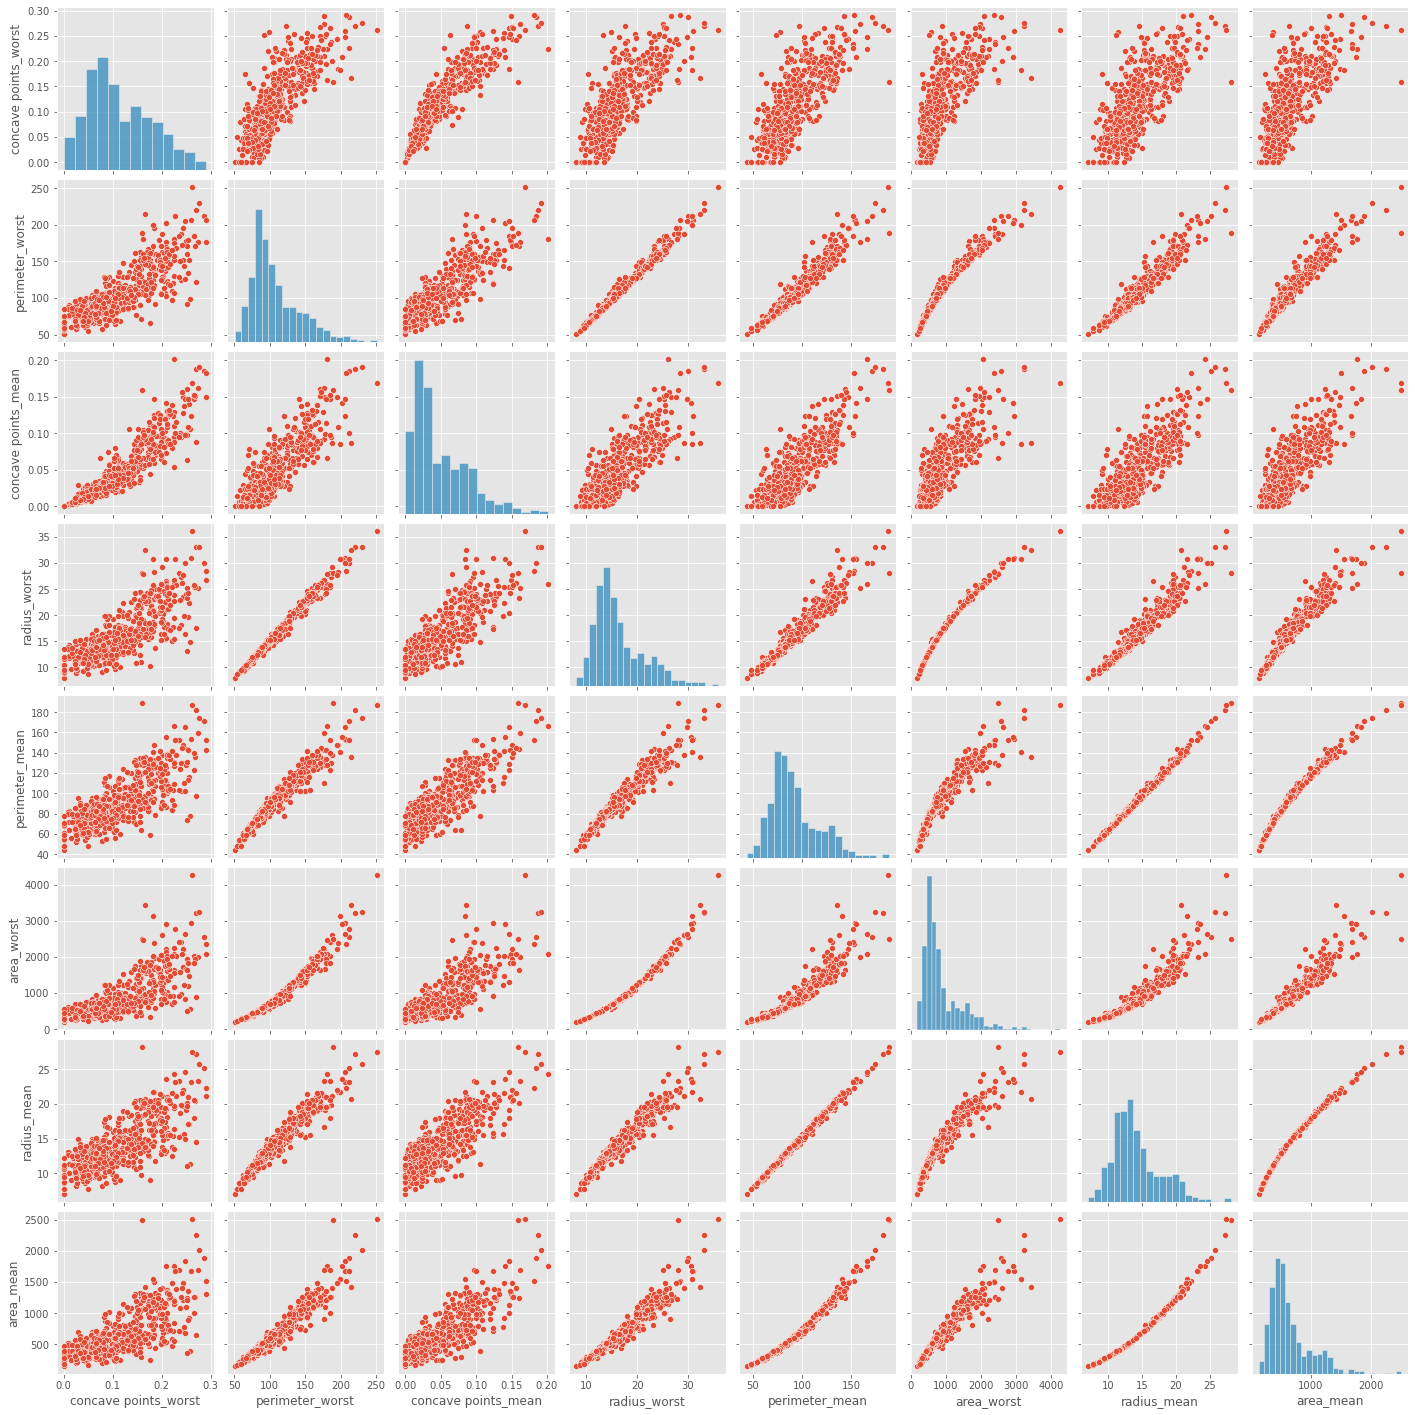

In [15]:
#Visualización de variables numéricas

sns.pairplot(d[df_filtrado['variable_1']])

In [16]:
#Eliminar la variable de salida de la lista de variable numéricas
numCols.remove('diagnosis')

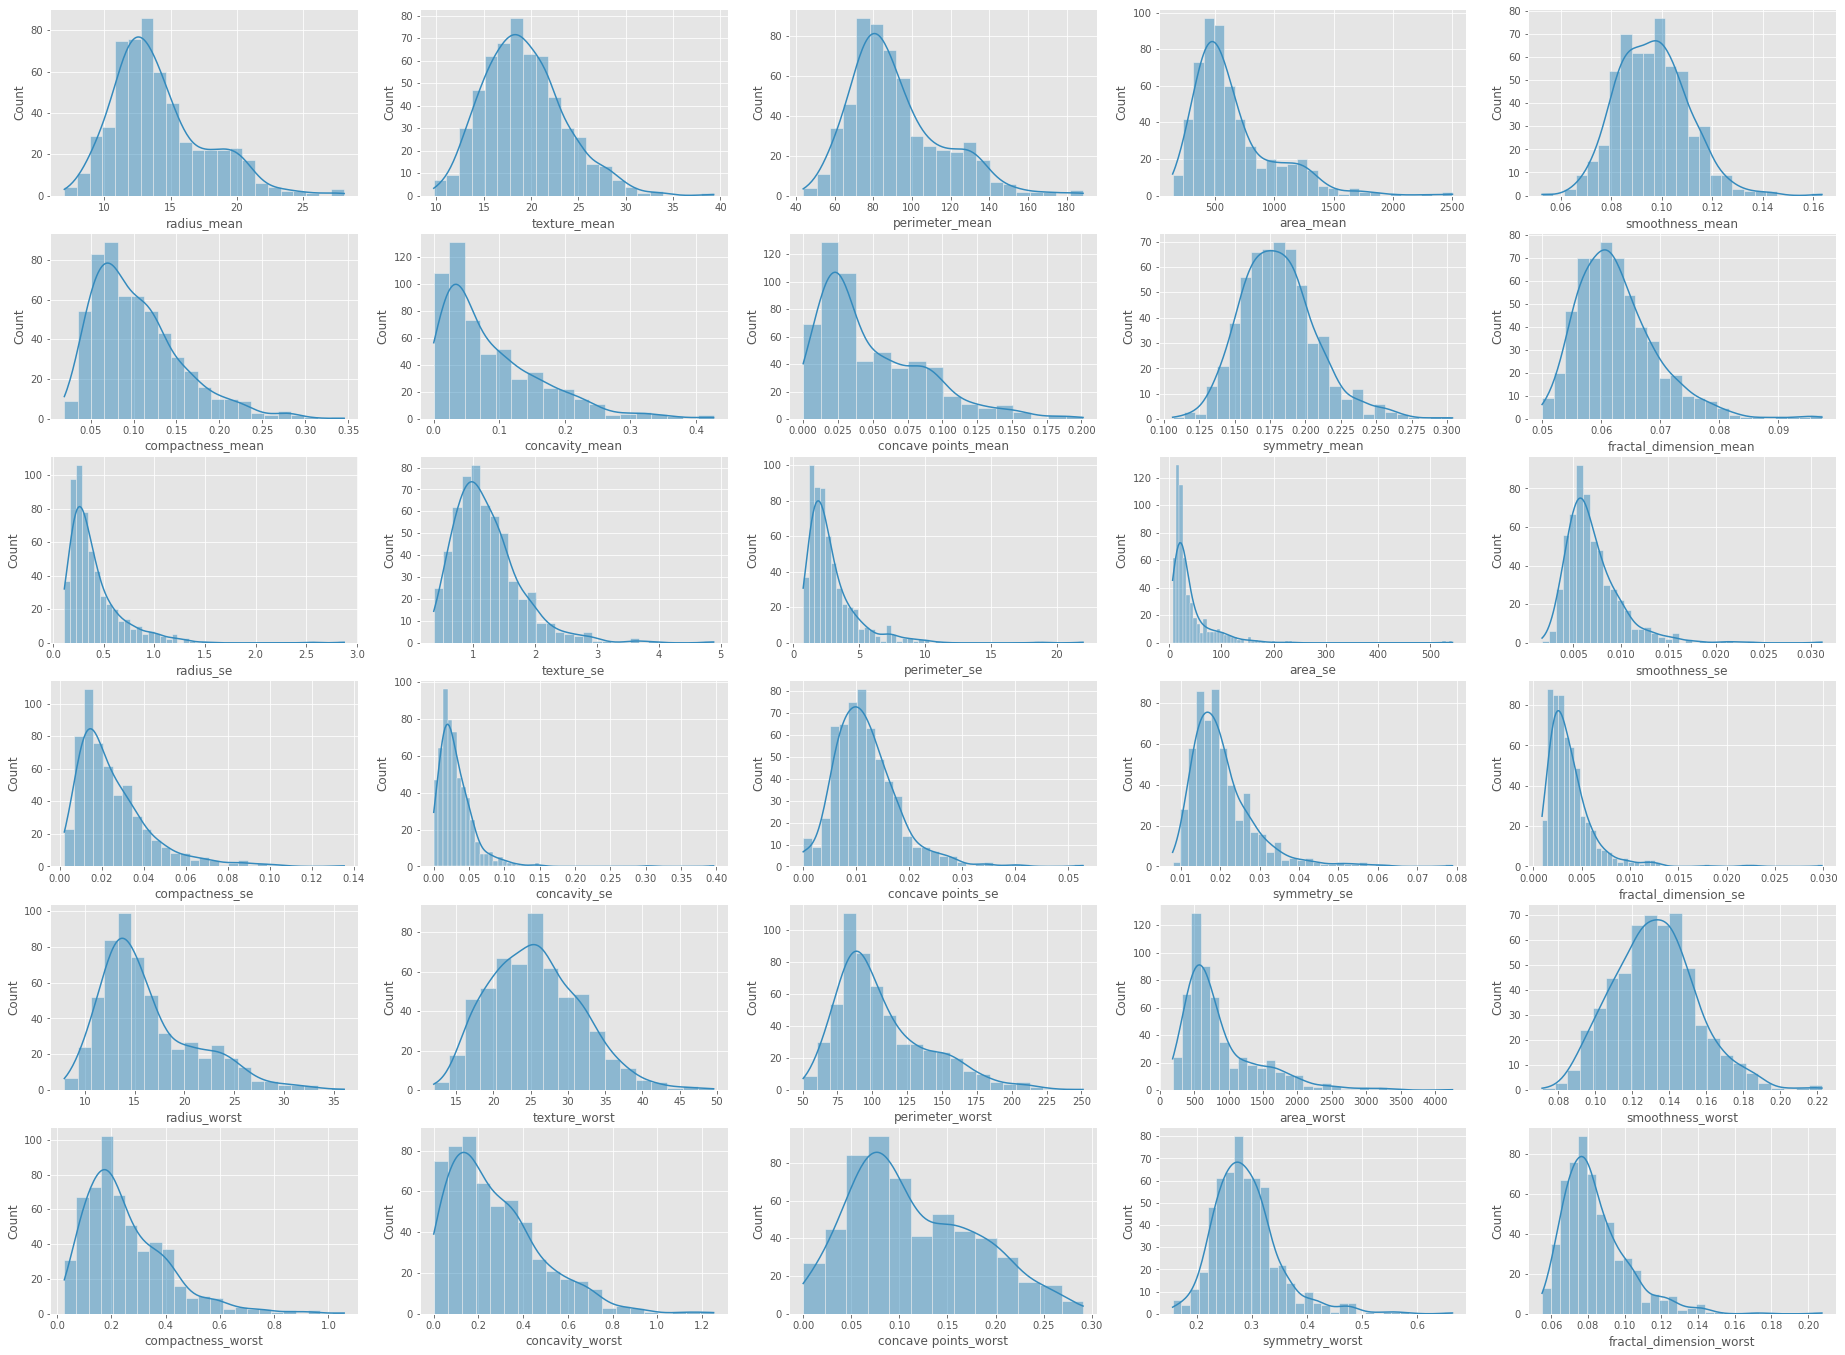

In [17]:
#Matriz de gráficos de histograma de todas las variables de entrada

# Se establecen la cantidad de columnas y filas para la matriz de gráficos
num_cols = 5
num_rows = 6

# Configuración del tamaño de la figura
figsize=(32,24)
plt.rcParams['figure.figsize'] = figsize
        
# Creación de la figura y los ejes
fig, axs = plt.subplots(num_rows, num_cols)

# Iteración sobre las columnas numéricas
for ind, col in enumerate(numCols):
    
    # Cálculo de las coordenadas de subtrama
    i = math.floor(ind/num_cols)
    j = ind - i*num_cols
    
    # Creación del histograma con estimación de densidad de kernel
    sns.histplot(d[col], ax=axs[i, j], kde=True)

### Variable de salida

In [18]:
# Distriución de la variable de salida

d['diagnosis'].value_counts()

1    357
0    212
Name: diagnosis, dtype: int64

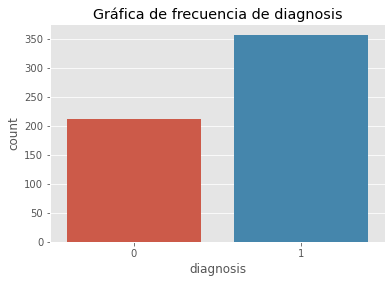

In [19]:
# Gráfica de frecuencia de diagnosis

plt.figure(figsize=(6,4))

plt.title('Gráfica de frecuencia de diagnosis')
sns.countplot(d.diagnosis)

plt.show()

### Análisis 

In [20]:
# Se crean dos dataframes, uno con diagnosis M:Malignant Tumor y otro con B:Benign Tumor

dfM = d[d.diagnosis == 0]
dfB = d[d.diagnosis == 1]

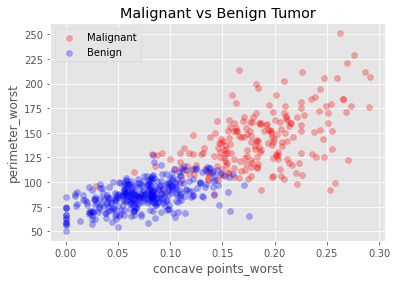

In [21]:
# Gráfica de las variables más influencian la variable de salida

figsize=(6,4)

plt.rcParams['figure.figsize'] = figsize

plt.title("Malignant vs Benign Tumor")
plt.xlabel('concave points_worst')
plt.ylabel('perimeter_worst')
plt.scatter(dfM['concave points_worst'], dfM['perimeter_worst'], color = "red", label = "Malignant", alpha = 0.3)
plt.scatter(dfB['concave points_worst'], dfB['perimeter_worst'], color = "blue", label = "Benign", alpha = 0.3)
plt.legend()
plt.show()

## 5. Preparación de datos

No se estableció ninguna transformación adicional a las realizadas previamente

## 6. Creación del modelo

In [22]:
# División de los datos en train y test
# ==============================================================================

X = d.drop(columns = 'diagnosis')
y = d['diagnosis']

In [23]:
# Se crean los datasets de entrenamiento y prueba para las variables de entrada y salida 

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1), 
                                        train_size   = 0.8,
                                        random_state = 123,
                                        shuffle      = True
                                    )

In [24]:
#Se establecen las variables numéricas a escalar

#Num_vars se le asigna la lista con las variables numerivas para posteriormente escalarlas
num_vars = numCols

print(num_vars)

['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


In [25]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Se crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.fit_transform(X_test[num_vars])

X_train[num_vars].head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
190,0.3542,0.4408,0.3534,0.1978,0.4954,0.6736,0.4642,0.3289,0.6687,0.5362,...,0.2778,0.6664,0.2788,0.1419,0.4997,0.9942,0.6780,0.6089,0.7098,0.7592
134,0.5611,0.3990,0.5339,0.3951,0.3762,0.2214,0.2701,0.3403,0.3192,0.1540,...,0.5190,0.5101,0.4741,0.3453,0.4506,0.2059,0.3167,0.4739,0.3044,0.1785
386,0.2558,0.1284,0.2445,0.1351,0.2568,0.1622,0.1602,0.1259,0.2960,0.2439,...,0.1850,0.1835,0.1855,0.0847,0.1336,0.2234,0.2457,0.3141,0.2192,0.2815
118,0.4305,0.4336,0.4326,0.2711,0.5676,0.4663,0.4998,0.4711,0.5232,0.4918,...,0.4361,0.4861,0.3979,0.2671,0.7321,0.5021,0.5875,0.6990,0.3369,0.5948
316,0.2544,0.1280,0.2338,0.1348,0.2231,0.0176,0.0263,0.0251,0.3096,0.1375,...,0.1750,0.1074,0.1553,0.0806,0.1156,0.0112,0.0329,0.0636,0.1435,0.0452


## 8. Creación del modelo

Las características de los modelos Naive Bayes son las siguientes:

**GaussianNB**: Este modelo se utiliza cuando las características de entrada se distribuyen de acuerdo con una distribución gaussiana (normal). <u>Es adecuado para variables numéricas continuas</u>.

**MultinomialNB**: Este modelo se utiliza cuando las características de entrada son variables categóricas con recuento discreto. <u>Es adecuado para variables categóricas que representan recuentos o frecuencias</u>.

**BernoulliNB**: Este modelo se utiliza cuando las características de entrada son variables binarias o se pueden binarizar. Es decir, cada característica representa la presencia o ausencia de algo. <u>Es adecuado para variables categóricas binarias o variables que se pueden convertir en binarias</u>. Los valores de características mayores que el umbral se establecen en 1, mientras que los valores iguales o inferiores al umbral se establecen en 0. El umbral se define mediante el parámetro **binarize**, que especifica el valor de corte para la binarización.

In [26]:
#Creación del modelo 

modelGNB       = GaussianNB()
modelBNB       = BernoulliNB(binarize=0.5)
modelMNB       = MultinomialNB()

#Entrenamiento 

modelGNB.fit(X_train, y_train)
modelBNB.fit(X_train, y_train)
modelMNB.fit(X_train, y_train)

MultinomialNB()

### Evaluación del modelo

In [27]:
y_modelGNB = modelGNB.predict(X_test)
y_modelBNB = modelBNB.predict(X_test)
y_modelMNB = modelMNB.predict(X_test)

#### Exactitud (Accuracy)

In [28]:
print("="*5 + f" Accuracy Gaussian NB " + "="*20)
print()
print("modelGNB:",metrics.accuracy_score(y_test, y_modelGNB))
print("modelBNB:",metrics.accuracy_score(y_test, y_modelBNB))
print("modelMNB:",metrics.accuracy_score(y_test, y_modelMNB))

===== Accuracy Gaussian NB ====================

modelGNB: 0.9736842105263158
modelBNB: 0.9385964912280702
modelMNB: 0.7543859649122807


#### Matriz de confusión

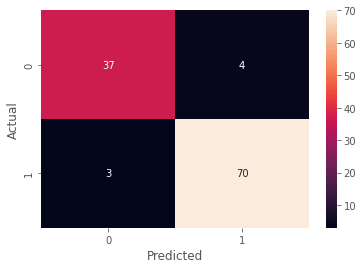

              precision    recall  f1-score   support

           0       0.93      0.90      0.91        41
           1       0.95      0.96      0.95        73

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114



In [29]:
#Matriz de confusión

conf_mat = confusion_matrix(y_test, y_modelBNB)

fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat
            , annot=True
            , fmt='d'
            , xticklabels=d['diagnosis'].sort_values().unique()
            , yticklabels=d['diagnosis'].sort_values().unique()
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(y_test, y_modelBNB))

#### ROC - Receiver Operating Characteristic

AUC: 0.96


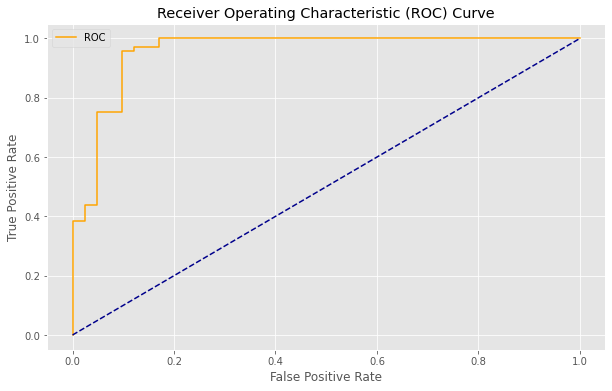

In [30]:
fig = plt.figure(figsize=(10,6))

# Predecir las probabilidades de la clase positiva usando el modelo de regresión logística entrenado
probs = modelBNB.predict_proba(X_test)

# Tomar las probabilidades de la clase positiva solamente
probs = probs[:, 1]

# Calcular el área bajo la curva ROC
auc = roc_auc_score(pd.DataFrame(y_test), probs*(1))

# Imprimir el valor del AUC
print('AUC: %.2f' % auc)

# Calcular la curva ROC usando los valores verdaderos y las probabilidades predichas
fpr, tpr, thresholds = roc_curve(pd.DataFrame(y_test), probs*(1))

# Graficar la curva ROC
plot_roc_curve(fpr, tpr)


##Nota: es necesario que la variable de salida sea numérica, sino debe transformarse

### Referencias

- https://www.analyticsvidhya.com/blog/2021/11/implementation-of-gaussian-naive-bayes-in-python-sklearn/

- Multinomial: https://www.youtube.com/watch?v=99MN-rl8jGY&t=90s